# Pennsylvania Traffic Crash Data - Comprehensive EDA

## ML Problem: Predict Severe Traffic Crash Counts by County-Month-Season

**Objective:** Forecast the number of severe traffic crashes (fatal or suspected serious injury) that will occur in a given Pennsylvania county during a future month and season.

**Why This Matters:** Unlike individual crash severity classification (which is reactive), county-month forecasting enables **proactive resource allocation** for emergency services, law enforcement, and transportation agencies.

**Target Variable:** `TARGET_SEVERE` (aggregated to county-month level)

---

In [1]:
# ============================================================================
# CELL 1: IMPORTS AND CONFIGURATION
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Professional plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titleweight'] = 'bold'

# Custom color palettes for consistency
SEVERITY_COLORS = {'Non-Severe': '#2ecc71', 'Severe': '#e74c3c'}
SEASON_COLORS = {'Winter': '#3498db', 'Spring': '#27ae60', 'Summer': '#f39c12', 'Fall': '#e67e22'}
URBAN_RURAL_COLORS = {'Rural': '#8e44ad', 'Urban': '#2980b9', 'Urbanized': '#16a085'}

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# ============================================================================
# CELL 2: LOAD DATA AND DECODE
# ============================================================================

# Load the ETL output
df_crash = pd.read_csv("pa_crash_data_mlp_ready.csv", low_memory=False)

# Import the decoder
from pa_crash_dictionary import CRASH_DICTIONARY, decode_df

# Decode dataframe: adds *_DESC columns for human-readable labels
df_crash = decode_df(df_crash, CRASH_DICTIONARY, make_desc_col=True)

print(f"Dataset loaded: {df_crash.shape[0]:,} crashes, {df_crash.shape[1]} columns")
print(f"Year range: {df_crash['CRASH_YEAR'].min()} - {df_crash['CRASH_YEAR'].max()}")

Dataset loaded: 2,387,466 crashes, 112 columns
Year range: 2005 - 2024


In [3]:
# ============================================================================
# CELL 3: ADD DERIVED FEATURES FOR FORECASTING
# ============================================================================

def assign_season(month):
    """Assign meteorological season based on month."""
    if month in [12, 1, 2]:
        return "Winter"
    elif month in [3, 4, 5]:
        return "Spring"
    elif month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

# Add season
df_crash['SEASON'] = df_crash['CRASH_MONTH'].apply(assign_season)

# Create severity label for visualization
df_crash['SEVERITY_LABEL'] = df_crash['TARGET_SEVERE'].map({0: 'Non-Severe', 1: 'Severe'})

# Ensure COUNTY_DESC exists
if 'COUNTY_DESC' not in df_crash.columns:
    df_crash['COUNTY_DESC'] = df_crash['COUNTY'].map(CRASH_DICTIONARY['COUNTY'])

print("Derived features added: SEASON, SEVERITY_LABEL")
print(f"\nSeason distribution:")
print(df_crash['SEASON'].value_counts())

Derived features added: SEASON, SEVERITY_LABEL

Season distribution:
SEASON
Winter    637290
Fall      628566
Summer    569274
Spring    552336
Name: count, dtype: int64


---
## 1. Dataset Overview & Quality Assessment
---

In [4]:
# ============================================================================
# CELL 4: DATASET OVERVIEW
# ============================================================================

print("=" * 70)
print("DATASET OVERVIEW")
print("=" * 70)
print(f"\nTotal Crash Records: {df_crash.shape[0]:,}")
print(f"Total Features: {df_crash.shape[1]}")
print(f"\nTemporal Coverage:")
print(f"  Years: {df_crash['CRASH_YEAR'].min()} to {df_crash['CRASH_YEAR'].max()}")
print(f"  Total Years: {df_crash['CRASH_YEAR'].nunique()}")
print(f"\nGeographic Coverage:")
print(f"  Counties: {df_crash['COUNTY'].nunique()} of 67 PA counties")
print(f"\nTarget Variable (Crash-Level):")
print(f"  Severe Crashes (Fatal/Serious Injury): {df_crash['TARGET_SEVERE'].sum():,} ({df_crash['TARGET_SEVERE'].mean()*100:.2f}%)")
print(f"  Non-Severe Crashes: {(df_crash['TARGET_SEVERE']==0).sum():,} ({(1-df_crash['TARGET_SEVERE'].mean())*100:.2f}%)")

DATASET OVERVIEW

Total Crash Records: 2,387,466
Total Features: 113

Temporal Coverage:
  Years: 2005 to 2024
  Total Years: 20

Geographic Coverage:
  Counties: 67 of 67 PA counties

Target Variable (Crash-Level):
  Severe Crashes (Fatal/Serious Injury): 91,885.0 (3.85%)
  Non-Severe Crashes: 2,295,581 (96.15%)


In [5]:
# ============================================================================
# CELL 5: MISSING VALUE ANALYSIS
# ============================================================================

missing = df_crash.isnull().sum()
missing_pct = (missing / len(df_crash) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing %', ascending=False)

if len(missing_df) > 0:
    print("\nColumns with Missing Values:")
    print(missing_df.head(20))
    
    # Visualize if there are missing values
    if len(missing_df) > 0 and missing_df['Missing %'].max() > 0:
        fig, ax = plt.subplots(figsize=(10, max(4, len(missing_df.head(15)) * 0.4)))
        colors = ['#e74c3c' if x > 10 else '#f39c12' if x > 1 else '#2ecc71' for x in missing_df.head(15)['Missing %']]
        bars = ax.barh(missing_df.head(15).index, missing_df.head(15)['Missing %'], color=colors)
        ax.set_xlabel('Missing Percentage (%)')
        ax.set_title('Missing Values by Feature (Top 15)')
        ax.invert_yaxis()
        for bar, pct in zip(bars, missing_df.head(15)['Missing %']):
            ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2, 
                   f'{pct:.1f}%', va='center', fontsize=9)
        plt.tight_layout()
        plt.show()
else:
    print("\n✓ No missing values in the dataset!")


✓ No missing values in the dataset!


---
## 2. Target Variable Analysis (Crash-Level & Aggregated)
---

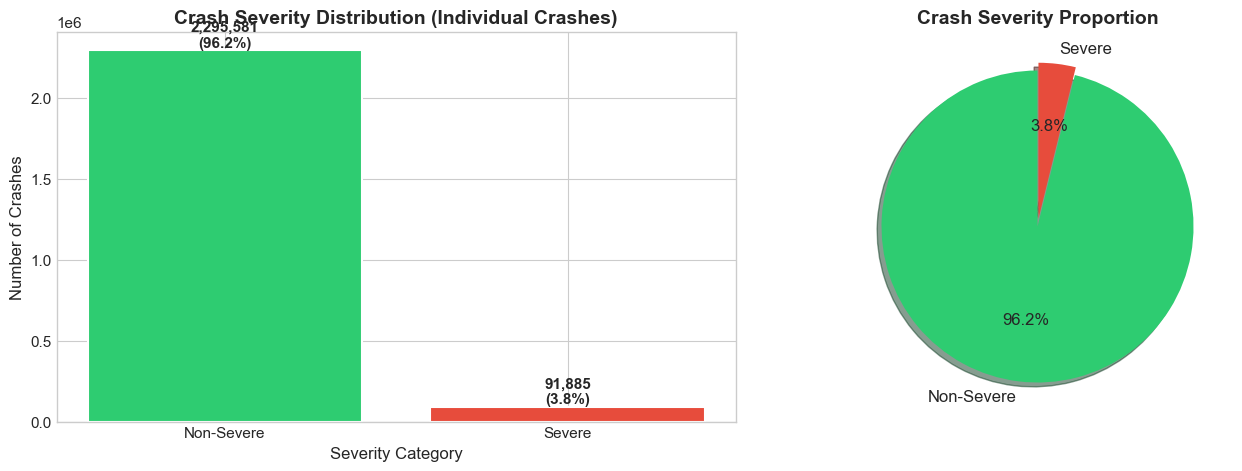


KEY INSIGHT: Class Imbalance Assessment
Imbalance Ratio: 25.0:1 (Non-Severe to Severe)
Severe crashes represent only 3.85% of all crashes


In [6]:
# ============================================================================
# CELL 6: TARGET VARIABLE - CRASH-LEVEL DISTRIBUTION
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Severity Distribution (Bar)
severity_counts = df_crash['SEVERITY_LABEL'].value_counts()
colors = [SEVERITY_COLORS[x] for x in severity_counts.index]
bars = axes[0].bar(severity_counts.index, severity_counts.values, color=colors, edgecolor='white', linewidth=1.5)
axes[0].set_title('Crash Severity Distribution (Individual Crashes)', fontweight='bold')
axes[0].set_ylabel('Number of Crashes')
axes[0].set_xlabel('Severity Category')
for bar in bars:
    height = bar.get_height()
    axes[0].annotate(f'{height:,.0f}\n({height/len(df_crash)*100:.1f}%)',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot 2: Severity Distribution (Pie)
axes[1].pie(severity_counts.values, labels=severity_counts.index, autopct='%1.1f%%',
           colors=colors, explode=[0, 0.05], shadow=True, startangle=90,
           textprops={'fontsize': 12})
axes[1].set_title('Crash Severity Proportion', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("KEY INSIGHT: Class Imbalance Assessment")
print("="*60)
imbalance_ratio = severity_counts['Non-Severe'] / severity_counts['Severe']
print(f"Imbalance Ratio: {imbalance_ratio:.1f}:1 (Non-Severe to Severe)")
print(f"Severe crashes represent only {severity_counts['Severe']/len(df_crash)*100:.2f}% of all crashes")

In [7]:
# ============================================================================
# CELL 7: CREATE AGGREGATED COUNTY-MONTH DATASET (FOR FORECASTING)
# ============================================================================

# Define aggregation features - these are the risk indicators we want to aggregate
flag_columns = [
    # Impairment factors
    'ALCOHOL_RELATED', 'DRINKING_DRIVER', 'DRUG_RELATED', 'IMPAIRED_DRIVER',
    # Behavioral factors
    'AGGRESSIVE_DRIVING', 'SPEEDING', 'SPEEDING_RELATED', 'DISTRACTED', 'CELL_PHONE',
    'TAILGATING', 'RUNNING_RED_LT', 'RUNNING_STOP_SIGN', 'UNBELTED',
    # Environmental/Road factors
    'ICY_ROAD', 'SNOW_SLUSH_ROAD', 'WET_ROAD', 'ILLUMINATION_DARK', 'CURVED_ROAD',
    # Road type
    'INTERSTATE', 'STATE_ROAD', 'LOCAL_ROAD', 'INTERSECTION',
    # Crash type
    'ANGLE_CRASH', 'REAR_END', 'HO_OPPDIR_SDSWP', 'SINGLE_VEHICLE', 'OVERTURNED',
    # Vehicle types
    'MOTORCYCLE', 'BICYCLE', 'HVY_TRUCK_RELATED', 'COMM_VEHICLE',
    # Driver age
    'YOUNG_DRIVER', 'MATURE_DRIVER', 'DRIVER_16YR', 'DRIVER_75PLUS',
    # Urban/Rural indicators
    'URBAN', 'RURAL'
]

# Filter to columns that exist
existing_flags = [c for c in flag_columns if c in df_crash.columns]

# Aggregation dictionary
agg_dict = {
    'TARGET_SEVERE': 'sum',  # Count of severe crashes - OUR TARGET
    'CRN': 'count',  # Total crash count
}

# Add sum aggregation for all flag columns
for col in existing_flags:
    agg_dict[col] = 'sum'

# Create the aggregated dataset
df_monthly = df_crash.groupby(['COUNTY', 'COUNTY_DESC', 'CRASH_YEAR', 'CRASH_MONTH', 'SEASON']).agg(agg_dict).reset_index()

# Rename for clarity
df_monthly.rename(columns={
    'TARGET_SEVERE': 'SEVERE_CRASH_COUNT',
    'CRN': 'TOTAL_CRASH_COUNT'
}, inplace=True)

# Calculate severe crash rate
df_monthly['SEVERE_CRASH_RATE'] = (df_monthly['SEVERE_CRASH_COUNT'] / df_monthly['TOTAL_CRASH_COUNT'] * 100).round(2)

print(f"Aggregated Dataset Created: {df_monthly.shape[0]:,} county-month observations")
print(f"\nTarget Variable: SEVERE_CRASH_COUNT")
print(df_monthly['SEVERE_CRASH_COUNT'].describe())

Aggregated Dataset Created: 16,068 county-month observations

Target Variable: SEVERE_CRASH_COUNT
count   16068.00
mean        5.72
std         6.88
min         0.00
25%         1.00
50%         3.00
75%         7.00
max        79.00
Name: SEVERE_CRASH_COUNT, dtype: float64


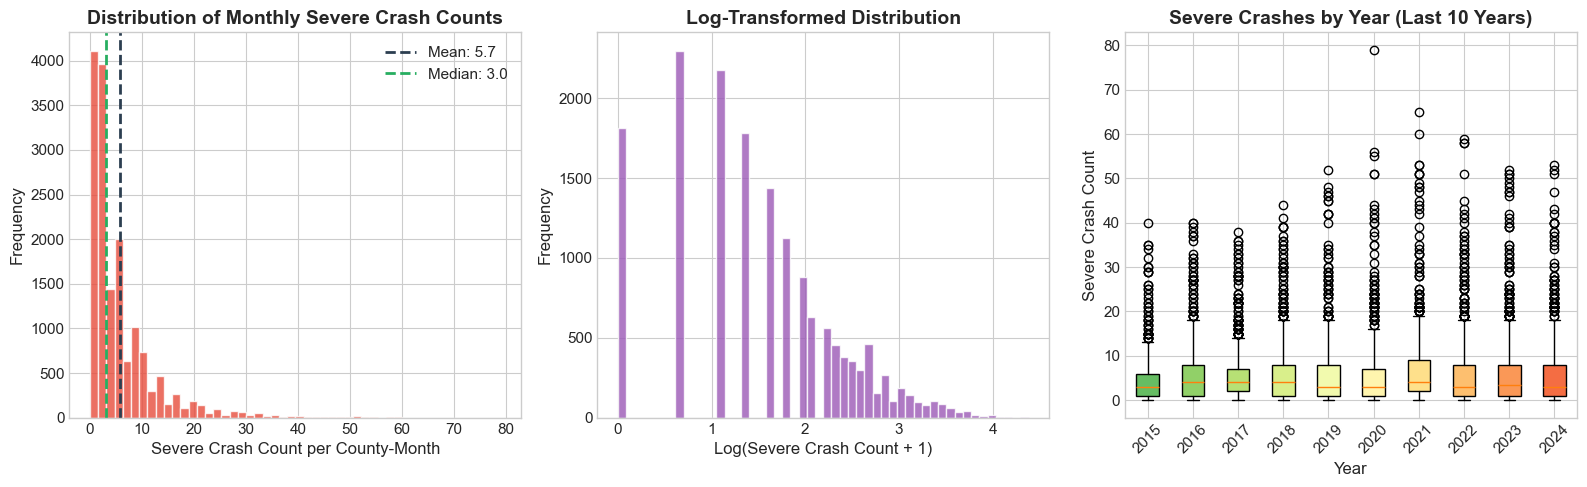


TARGET VARIABLE STATISTICS (County-Month Level)
Mean: 5.72
Median: 3.00
Std Dev: 6.88
Skewness: 2.71
Kurtosis: 10.46
Range: 0.0 - 79.0


In [8]:
# ============================================================================
# CELL 8: TARGET DISTRIBUTION AT COUNTY-MONTH LEVEL
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: Histogram of Severe Crash Counts
axes[0].hist(df_monthly['SEVERE_CRASH_COUNT'], bins=50, color='#e74c3c', edgecolor='white', alpha=0.8)
axes[0].axvline(df_monthly['SEVERE_CRASH_COUNT'].mean(), color='#2c3e50', linestyle='--', 
               linewidth=2, label=f'Mean: {df_monthly["SEVERE_CRASH_COUNT"].mean():.1f}')
axes[0].axvline(df_monthly['SEVERE_CRASH_COUNT'].median(), color='#27ae60', linestyle='--', 
               linewidth=2, label=f'Median: {df_monthly["SEVERE_CRASH_COUNT"].median():.1f}')
axes[0].set_xlabel('Severe Crash Count per County-Month')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Monthly Severe Crash Counts', fontweight='bold')
axes[0].legend()

# Plot 2: Log-transformed histogram (to see right tail)
axes[1].hist(np.log1p(df_monthly['SEVERE_CRASH_COUNT']), bins=50, color='#9b59b6', edgecolor='white', alpha=0.8)
axes[1].set_xlabel('Log(Severe Crash Count + 1)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Log-Transformed Distribution', fontweight='bold')

# Plot 3: Box plot by year
yearly_data = [df_monthly[df_monthly['CRASH_YEAR'] == y]['SEVERE_CRASH_COUNT'].values 
               for y in sorted(df_monthly['CRASH_YEAR'].unique())[-10:]]  # Last 10 years
bp = axes[2].boxplot(yearly_data, labels=sorted(df_monthly['CRASH_YEAR'].unique())[-10:], patch_artist=True)
colors_bp = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(yearly_data)))
for patch, color in zip(bp['boxes'], colors_bp):
    patch.set_facecolor(color)
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Severe Crash Count')
axes[2].set_title('Severe Crashes by Year (Last 10 Years)', fontweight='bold')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Statistical summary
print("\n" + "="*60)
print("TARGET VARIABLE STATISTICS (County-Month Level)")
print("="*60)
print(f"Mean: {df_monthly['SEVERE_CRASH_COUNT'].mean():.2f}")
print(f"Median: {df_monthly['SEVERE_CRASH_COUNT'].median():.2f}")
print(f"Std Dev: {df_monthly['SEVERE_CRASH_COUNT'].std():.2f}")
print(f"Skewness: {df_monthly['SEVERE_CRASH_COUNT'].skew():.2f}")
print(f"Kurtosis: {df_monthly['SEVERE_CRASH_COUNT'].kurtosis():.2f}")
print(f"Range: {df_monthly['SEVERE_CRASH_COUNT'].min()} - {df_monthly['SEVERE_CRASH_COUNT'].max()}")

---
## 3. Temporal Analysis (Critical for Forecasting)
---

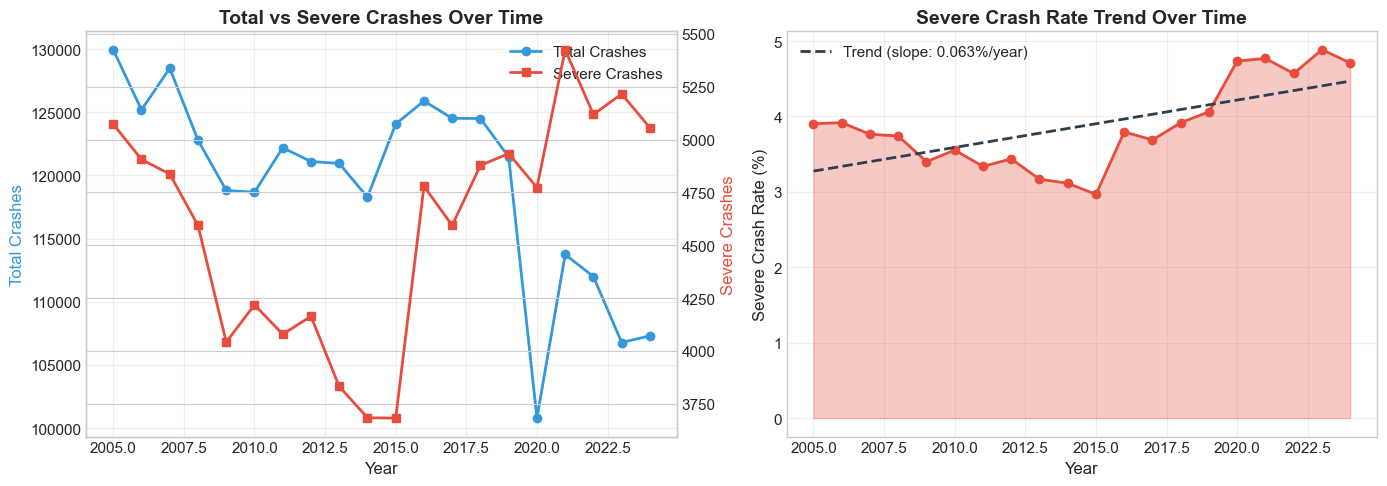

In [9]:
# ============================================================================
# CELL 9: YEARLY TRENDS IN SEVERE CRASHES
# ============================================================================

yearly_agg = df_crash.groupby('CRASH_YEAR').agg({
    'TARGET_SEVERE': ['sum', 'mean'],
    'CRN': 'count'
}).reset_index()
yearly_agg.columns = ['Year', 'Severe_Crashes', 'Severe_Rate', 'Total_Crashes']
yearly_agg['Severe_Rate'] = yearly_agg['Severe_Rate'] * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Absolute counts over time
ax1_twin = axes[0].twinx()
line1 = axes[0].plot(yearly_agg['Year'], yearly_agg['Total_Crashes'], 'o-', 
                     color='#3498db', linewidth=2, markersize=6, label='Total Crashes')
line2 = ax1_twin.plot(yearly_agg['Year'], yearly_agg['Severe_Crashes'], 's-', 
                      color='#e74c3c', linewidth=2, markersize=6, label='Severe Crashes')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Total Crashes', color='#3498db')
ax1_twin.set_ylabel('Severe Crashes', color='#e74c3c')
axes[0].set_title('Total vs Severe Crashes Over Time', fontweight='bold')
lines = line1 + line2
labels = [l.get_label() for l in lines]
axes[0].legend(lines, labels, loc='upper right')
axes[0].grid(True, alpha=0.3)

# Plot 2: Severe crash rate over time
axes[1].fill_between(yearly_agg['Year'], yearly_agg['Severe_Rate'], alpha=0.3, color='#e74c3c')
axes[1].plot(yearly_agg['Year'], yearly_agg['Severe_Rate'], 'o-', color='#e74c3c', 
            linewidth=2, markersize=6)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Severe Crash Rate (%)')
axes[1].set_title('Severe Crash Rate Trend Over Time', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(yearly_agg['Year'], yearly_agg['Severe_Rate'], 1)
p = np.poly1d(z)
axes[1].plot(yearly_agg['Year'], p(yearly_agg['Year']), '--', color='#2c3e50', 
            linewidth=2, label=f'Trend (slope: {z[0]:.3f}%/year)')
axes[1].legend()

plt.tight_layout()
plt.show()

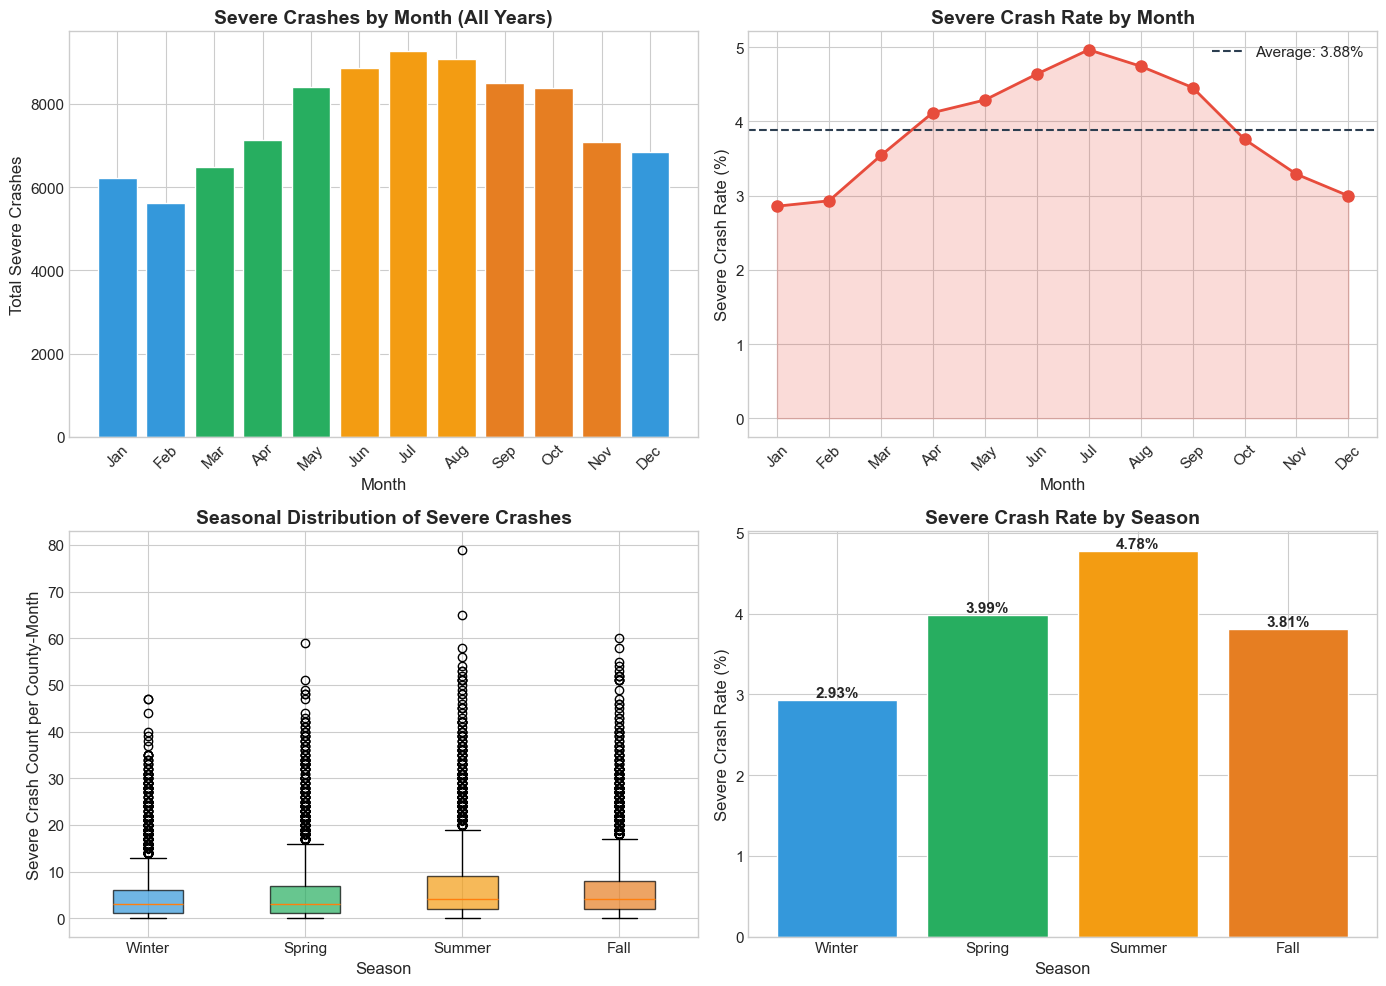


SEASONAL INSIGHTS FOR FORECASTING
Winter: 2.93% severe crash rate
Spring: 3.99% severe crash rate
Summer: 4.78% severe crash rate
Fall: 3.81% severe crash rate


In [10]:
# ============================================================================
# CELL 10: MONTHLY AND SEASONAL PATTERNS
# ============================================================================

# Monthly aggregation
monthly_agg = df_crash.groupby('CRASH_MONTH').agg({
    'TARGET_SEVERE': ['sum', 'mean', 'count']
}).reset_index()
monthly_agg.columns = ['Month', 'Severe_Count', 'Severe_Rate', 'Total_Crashes']
monthly_agg['Severe_Rate'] = monthly_agg['Severe_Rate'] * 100
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_agg['Month_Name'] = month_names

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Monthly severe crash counts
colors_month = ['#3498db' if m in [12,1,2] else '#27ae60' if m in [3,4,5] 
               else '#f39c12' if m in [6,7,8] else '#e67e22' for m in range(1,13)]
axes[0,0].bar(monthly_agg['Month_Name'], monthly_agg['Severe_Count'], color=colors_month, edgecolor='white')
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Total Severe Crashes')
axes[0,0].set_title('Severe Crashes by Month (All Years)', fontweight='bold')
axes[0,0].tick_params(axis='x', rotation=45)

# Plot 2: Monthly severe crash rate
axes[0,1].plot(monthly_agg['Month_Name'], monthly_agg['Severe_Rate'], 'o-', 
              color='#e74c3c', linewidth=2, markersize=8)
axes[0,1].fill_between(monthly_agg['Month_Name'], monthly_agg['Severe_Rate'], alpha=0.2, color='#e74c3c')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Severe Crash Rate (%)')
axes[0,1].set_title('Severe Crash Rate by Month', fontweight='bold')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].axhline(y=monthly_agg['Severe_Rate'].mean(), color='#2c3e50', linestyle='--', 
                 label=f'Average: {monthly_agg["Severe_Rate"].mean():.2f}%')
axes[0,1].legend()

# Plot 3: Seasonal comparison (box plot)
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
season_data = [df_monthly[df_monthly['SEASON'] == s]['SEVERE_CRASH_COUNT'].values for s in season_order]
bp = axes[1,0].boxplot(season_data, labels=season_order, patch_artist=True)
for patch, season in zip(bp['boxes'], season_order):
    patch.set_facecolor(SEASON_COLORS[season])
    patch.set_alpha(0.7)
axes[1,0].set_xlabel('Season')
axes[1,0].set_ylabel('Severe Crash Count per County-Month')
axes[1,0].set_title('Seasonal Distribution of Severe Crashes', fontweight='bold')

# Plot 4: Seasonal severe crash rates
seasonal_agg = df_crash.groupby('SEASON').agg({'TARGET_SEVERE': ['sum', 'mean']}).reset_index()
seasonal_agg.columns = ['Season', 'Severe_Count', 'Severe_Rate']
seasonal_agg['Severe_Rate'] = seasonal_agg['Severe_Rate'] * 100
seasonal_agg = seasonal_agg.set_index('Season').reindex(season_order).reset_index()

bars = axes[1,1].bar(seasonal_agg['Season'], seasonal_agg['Severe_Rate'], 
                    color=[SEASON_COLORS[s] for s in seasonal_agg['Season']], edgecolor='white')
axes[1,1].set_xlabel('Season')
axes[1,1].set_ylabel('Severe Crash Rate (%)')
axes[1,1].set_title('Severe Crash Rate by Season', fontweight='bold')
for bar in bars:
    height = bar.get_height()
    axes[1,1].annotate(f'{height:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                      ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("SEASONAL INSIGHTS FOR FORECASTING")
print("="*60)
for _, row in seasonal_agg.iterrows():
    print(f"{row['Season']}: {row['Severe_Rate']:.2f}% severe crash rate")

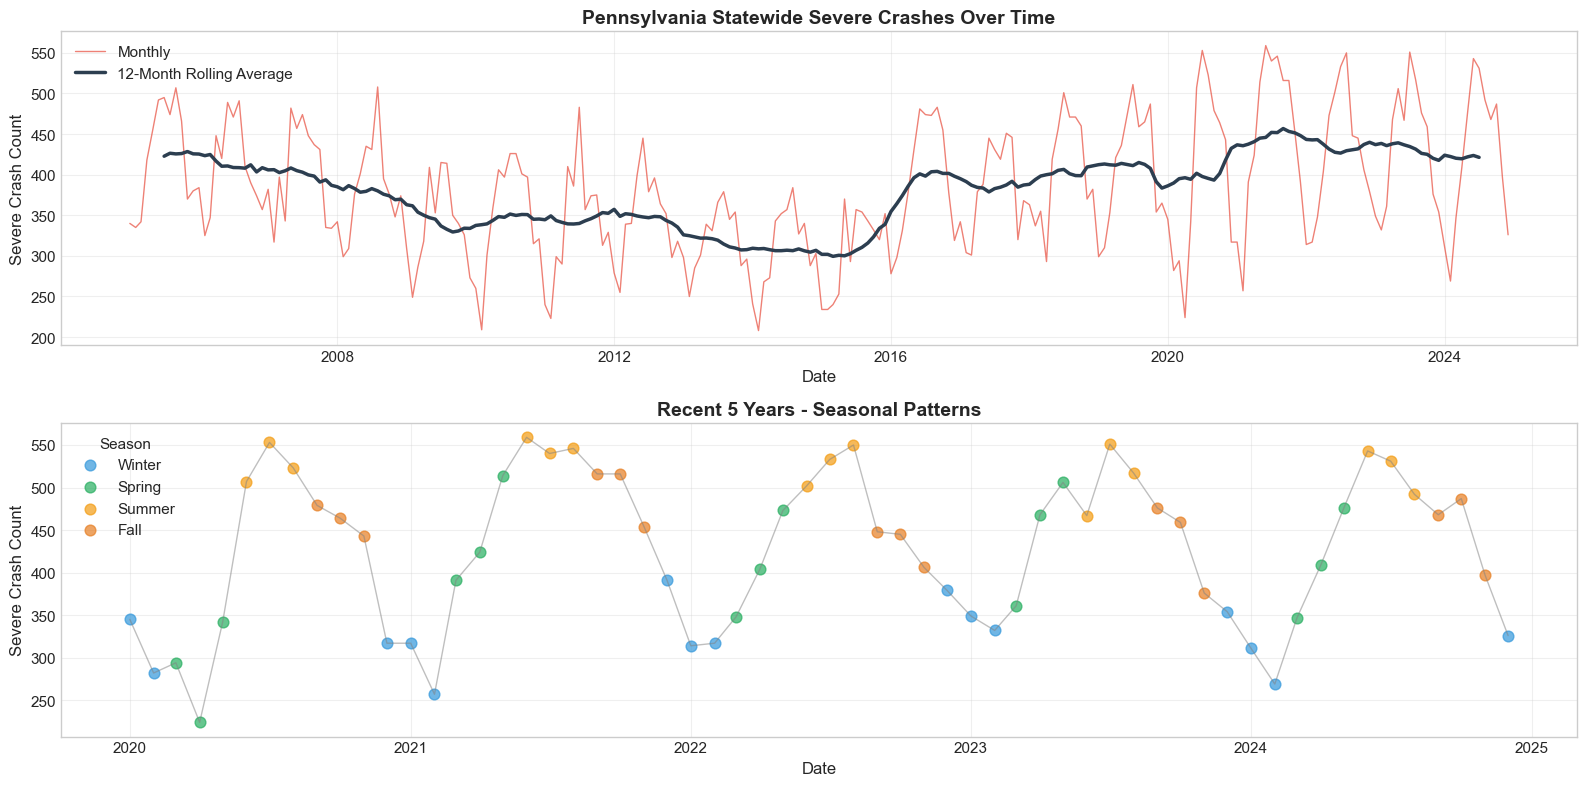

In [11]:
# ============================================================================
# CELL 11: TIME SERIES VISUALIZATION (STATE-LEVEL)
# ============================================================================

# State-level monthly aggregation
state_monthly = df_crash.groupby(['CRASH_YEAR', 'CRASH_MONTH']).agg({
    'TARGET_SEVERE': 'sum',
    'CRN': 'count'
}).reset_index()
state_monthly.columns = ['Year', 'Month', 'Severe_Crashes', 'Total_Crashes']
state_monthly['Date'] = pd.to_datetime(state_monthly['Year'].astype(str) + '-' + 
                                       state_monthly['Month'].astype(str).str.zfill(2) + '-01')
state_monthly = state_monthly.sort_values('Date')

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Plot 1: Full time series
axes[0].plot(state_monthly['Date'], state_monthly['Severe_Crashes'], color='#e74c3c', 
            linewidth=1, alpha=0.7, label='Monthly')
# Add 12-month rolling average
state_monthly['Rolling_12'] = state_monthly['Severe_Crashes'].rolling(window=12, center=True).mean()
axes[0].plot(state_monthly['Date'], state_monthly['Rolling_12'], color='#2c3e50', 
            linewidth=2.5, label='12-Month Rolling Average')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Severe Crash Count')
axes[0].set_title('Pennsylvania Statewide Severe Crashes Over Time', fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Last 5 years with seasonality highlighted
recent = state_monthly[state_monthly['Year'] >= state_monthly['Year'].max() - 4]
for season, color in SEASON_COLORS.items():
    if season == 'Winter':
        mask = recent['Month'].isin([12, 1, 2])
    elif season == 'Spring':
        mask = recent['Month'].isin([3, 4, 5])
    elif season == 'Summer':
        mask = recent['Month'].isin([6, 7, 8])
    else:
        mask = recent['Month'].isin([9, 10, 11])
    axes[1].scatter(recent[mask]['Date'], recent[mask]['Severe_Crashes'], 
                   color=color, s=60, alpha=0.7, label=season)
axes[1].plot(recent['Date'], recent['Severe_Crashes'], color='gray', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Severe Crash Count')
axes[1].set_title('Recent 5 Years - Seasonal Patterns', fontweight='bold')
axes[1].legend(title='Season')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## 4. Geographic Analysis (County-Level Patterns)
---

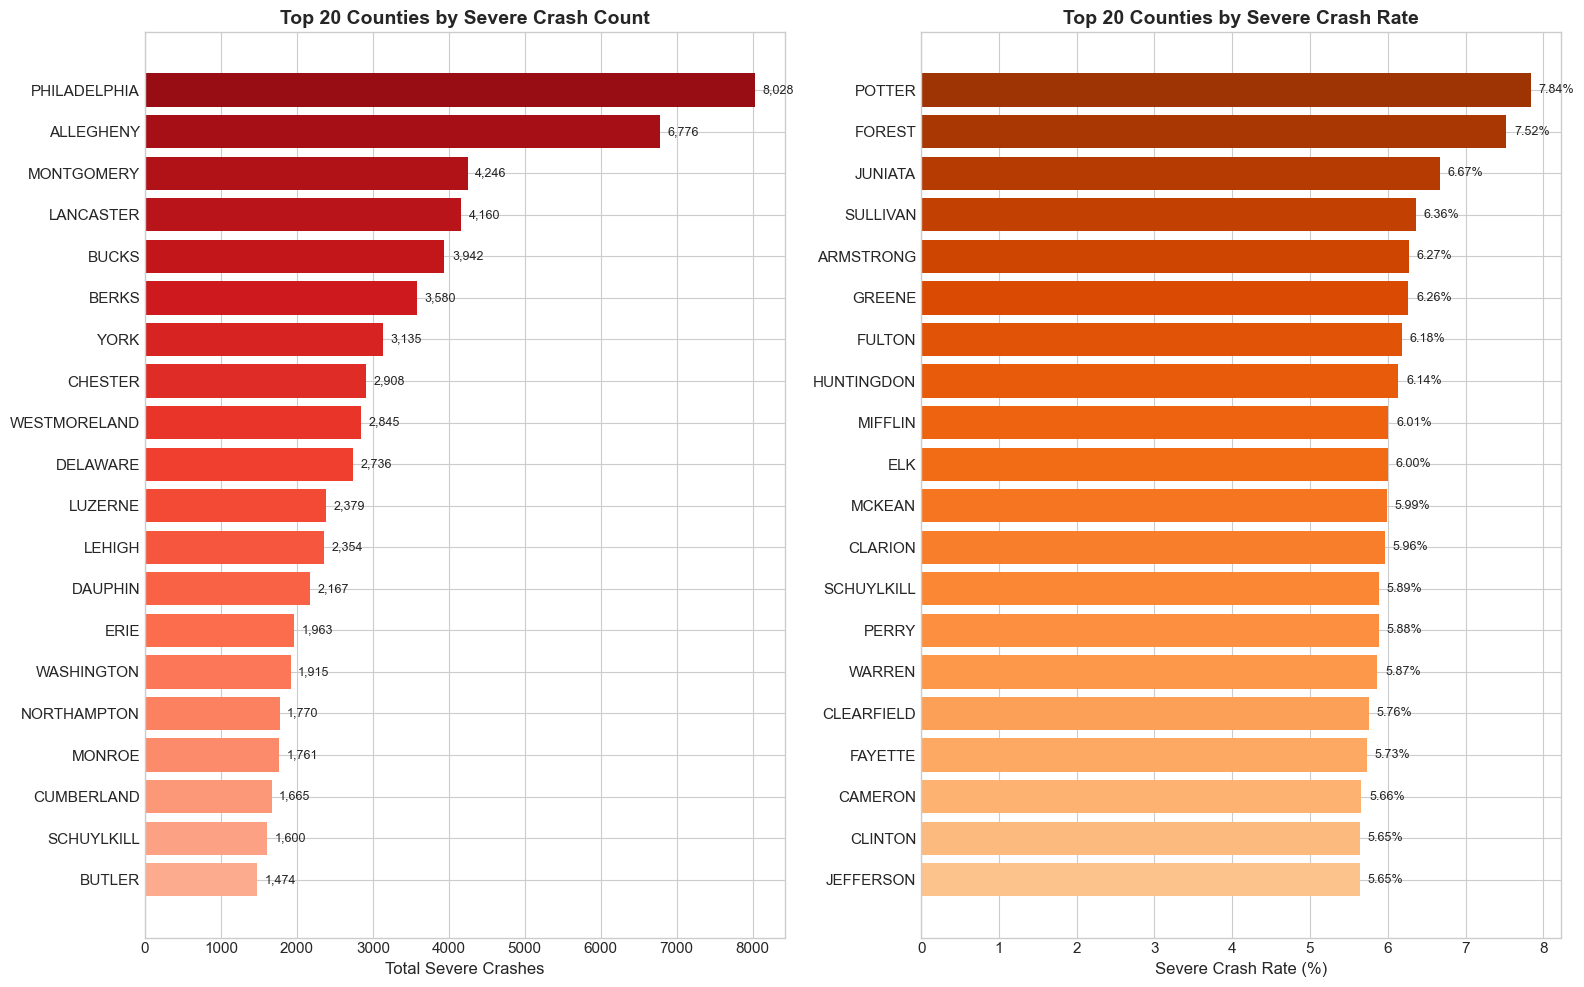


KEY INSIGHT: High-Volume vs High-Rate Counties

High-Volume Counties (most severe crashes in absolute numbers):
      County  Severe_Crashes  Total_Crashes
PHILADELPHIA         8028.00         204727
   ALLEGHENY         6776.00         226621
  MONTGOMERY         4246.00         165489
   LANCASTER         4160.00         109022
       BUCKS         3942.00         117785

High-Rate Counties (highest proportion of severe crashes):
   County  Severe_Rate  Total_Crashes
   POTTER         7.84           2640
   FOREST         7.52           1369
  JUNIATA         6.67           5125
 SULLIVAN         6.36           1493
ARMSTRONG         6.27          10475


In [12]:
# ============================================================================
# CELL 12: COUNTY-LEVEL SEVERE CRASH ANALYSIS
# ============================================================================

county_agg = df_crash.groupby('COUNTY_DESC').agg({
    'TARGET_SEVERE': ['sum', 'mean'],
    'CRN': 'count'
}).reset_index()
county_agg.columns = ['County', 'Severe_Crashes', 'Severe_Rate', 'Total_Crashes']
county_agg['Severe_Rate'] = county_agg['Severe_Rate'] * 100

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Plot 1: Top 20 counties by severe crash COUNT
top20_count = county_agg.nlargest(20, 'Severe_Crashes')
colors = plt.cm.Reds(np.linspace(0.3, 0.9, 20))[::-1]
axes[0].barh(top20_count['County'], top20_count['Severe_Crashes'], color=colors)
axes[0].set_xlabel('Total Severe Crashes')
axes[0].set_title('Top 20 Counties by Severe Crash Count', fontweight='bold')
axes[0].invert_yaxis()
for i, (_, row) in enumerate(top20_count.iterrows()):
    axes[0].text(row['Severe_Crashes'] + 100, i, f"{row['Severe_Crashes']:,.0f}", 
                va='center', fontsize=9)

# Plot 2: Top 20 counties by severe crash RATE
top20_rate = county_agg.nlargest(20, 'Severe_Rate')
colors_rate = plt.cm.Oranges(np.linspace(0.3, 0.9, 20))[::-1]
axes[1].barh(top20_rate['County'], top20_rate['Severe_Rate'], color=colors_rate)
axes[1].set_xlabel('Severe Crash Rate (%)')
axes[1].set_title('Top 20 Counties by Severe Crash Rate', fontweight='bold')
axes[1].invert_yaxis()
for i, (_, row) in enumerate(top20_rate.iterrows()):
    axes[1].text(row['Severe_Rate'] + 0.1, i, f"{row['Severe_Rate']:.2f}%", 
                va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("KEY INSIGHT: High-Volume vs High-Rate Counties")
print("="*70)
print("\nHigh-Volume Counties (most severe crashes in absolute numbers):")
print(top20_count[['County', 'Severe_Crashes', 'Total_Crashes']].head(5).to_string(index=False))
print("\nHigh-Rate Counties (highest proportion of severe crashes):")
print(top20_rate[['County', 'Severe_Rate', 'Total_Crashes']].head(5).to_string(index=False))

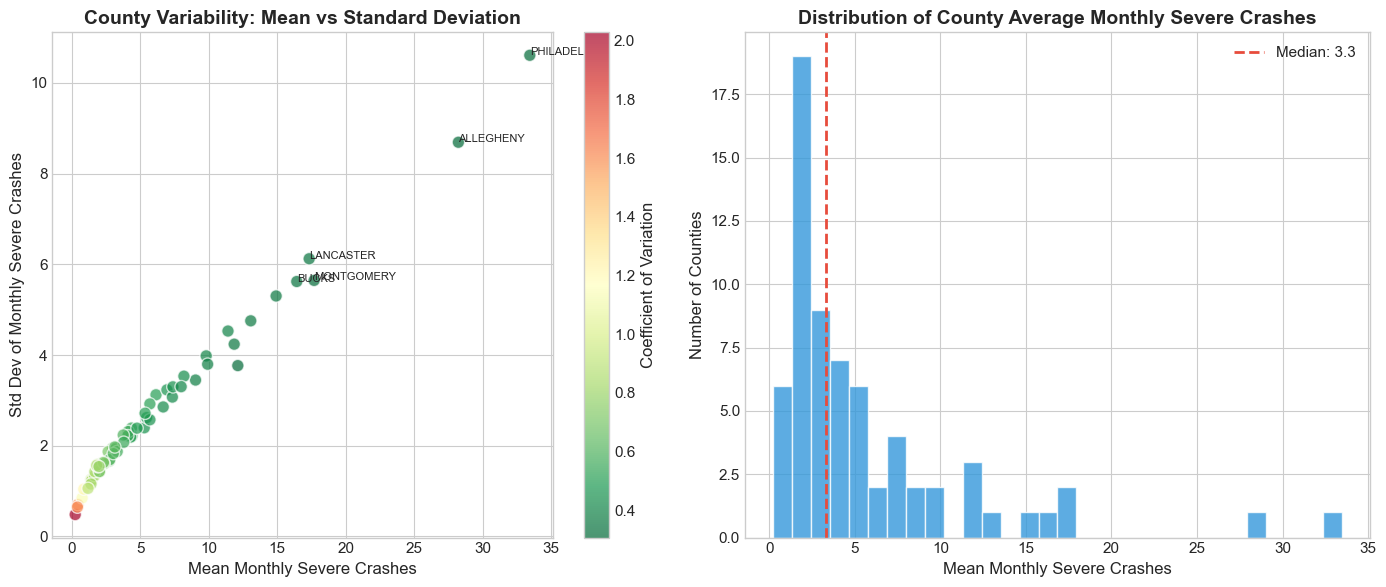


County Variability Summary:
  Most variable county: CAMERON (CV=2.03)
  Least variable county: ALLEGHENY (CV=0.31)


In [13]:
# ============================================================================
# CELL 13: COUNTY-LEVEL VARIABILITY (IMPORTANT FOR FORECASTING)
# ============================================================================

# Calculate monthly statistics per county
county_monthly_stats = df_monthly.groupby('COUNTY_DESC').agg({
    'SEVERE_CRASH_COUNT': ['mean', 'std', 'min', 'max']
}).reset_index()
county_monthly_stats.columns = ['County', 'Mean_Monthly', 'Std_Monthly', 'Min_Monthly', 'Max_Monthly']
county_monthly_stats['CV'] = county_monthly_stats['Std_Monthly'] / county_monthly_stats['Mean_Monthly']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Mean vs Std (variability pattern)
scatter = axes[0].scatter(county_monthly_stats['Mean_Monthly'], county_monthly_stats['Std_Monthly'],
                         c=county_monthly_stats['CV'], cmap='RdYlGn_r', s=80, alpha=0.7, edgecolors='white')
axes[0].set_xlabel('Mean Monthly Severe Crashes')
axes[0].set_ylabel('Std Dev of Monthly Severe Crashes')
axes[0].set_title('County Variability: Mean vs Standard Deviation', fontweight='bold')
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Coefficient of Variation')

# Annotate outliers
for _, row in county_monthly_stats.nlargest(5, 'Mean_Monthly').iterrows():
    axes[0].annotate(row['County'], (row['Mean_Monthly'], row['Std_Monthly']), fontsize=8)

# Plot 2: Distribution of county means
axes[1].hist(county_monthly_stats['Mean_Monthly'], bins=30, color='#3498db', edgecolor='white', alpha=0.8)
axes[1].axvline(county_monthly_stats['Mean_Monthly'].median(), color='#e74c3c', linestyle='--', 
               linewidth=2, label=f'Median: {county_monthly_stats["Mean_Monthly"].median():.1f}')
axes[1].set_xlabel('Mean Monthly Severe Crashes')
axes[1].set_ylabel('Number of Counties')
axes[1].set_title('Distribution of County Average Monthly Severe Crashes', fontweight='bold')
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nCounty Variability Summary:")
print(f"  Most variable county: {county_monthly_stats.loc[county_monthly_stats['CV'].idxmax(), 'County']} (CV={county_monthly_stats['CV'].max():.2f})")
print(f"  Least variable county: {county_monthly_stats.loc[county_monthly_stats['CV'].idxmin(), 'County']} (CV={county_monthly_stats['CV'].min():.2f})")

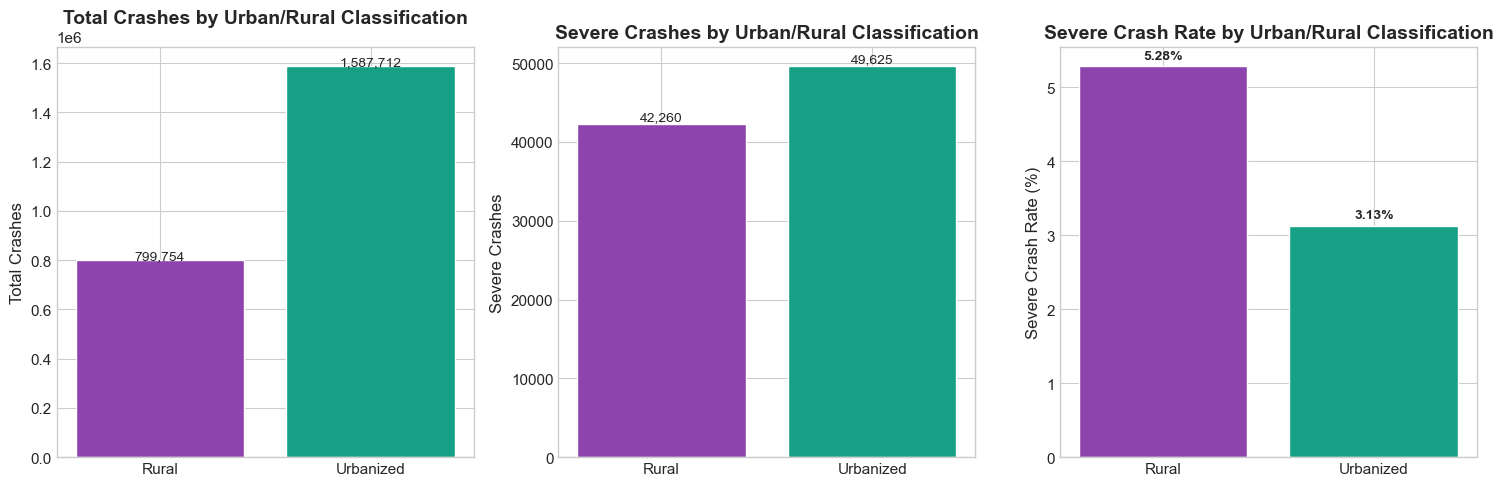


URBAN VS RURAL KEY FINDING
Rural severe crash rate: 5.28%
Urban severe crash rate: 0.00%
Rural crashes are infx more likely to be severe!


In [14]:
# ============================================================================
# CELL 14: URBAN VS RURAL ANALYSIS
# ============================================================================

# Create Urban/Rural classification at crash level
if 'URBAN_RURAL_DESC' not in df_crash.columns:
    df_crash['URBAN_RURAL_DESC'] = df_crash['URBAN_RURAL'].map(CRASH_DICTIONARY['URBAN_RURAL'])

urban_rural_agg = df_crash.groupby('URBAN_RURAL_DESC').agg({
    'TARGET_SEVERE': ['sum', 'mean'],
    'CRN': 'count'
}).reset_index()
urban_rural_agg.columns = ['Classification', 'Severe_Crashes', 'Severe_Rate', 'Total_Crashes']
urban_rural_agg['Severe_Rate'] = urban_rural_agg['Severe_Rate'] * 100

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Total crashes by classification
colors = [URBAN_RURAL_COLORS.get(x, '#95a5a6') for x in urban_rural_agg['Classification']]
axes[0].bar(urban_rural_agg['Classification'], urban_rural_agg['Total_Crashes'], color=colors, edgecolor='white')
axes[0].set_ylabel('Total Crashes')
axes[0].set_title('Total Crashes by Urban/Rural Classification', fontweight='bold')
for i, v in enumerate(urban_rural_agg['Total_Crashes']):
    axes[0].text(i, v + 5000, f'{v:,.0f}', ha='center', fontsize=10)

# Plot 2: Severe crashes by classification
axes[1].bar(urban_rural_agg['Classification'], urban_rural_agg['Severe_Crashes'], color=colors, edgecolor='white')
axes[1].set_ylabel('Severe Crashes')
axes[1].set_title('Severe Crashes by Urban/Rural Classification', fontweight='bold')
for i, v in enumerate(urban_rural_agg['Severe_Crashes']):
    axes[1].text(i, v + 500, f'{v:,.0f}', ha='center', fontsize=10)

# Plot 3: Severe crash rate by classification
axes[2].bar(urban_rural_agg['Classification'], urban_rural_agg['Severe_Rate'], color=colors, edgecolor='white')
axes[2].set_ylabel('Severe Crash Rate (%)')
axes[2].set_title('Severe Crash Rate by Urban/Rural Classification', fontweight='bold')
for i, v in enumerate(urban_rural_agg['Severe_Rate']):
    axes[2].text(i, v + 0.1, f'{v:.2f}%', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("URBAN VS RURAL KEY FINDING")
print("="*60)
rural_rate = urban_rural_agg[urban_rural_agg['Classification'] == 'Rural']['Severe_Rate'].values[0]
urban_rate = urban_rural_agg[urban_rural_agg['Classification'] == 'Urban']['Severe_Rate'].values[0] if 'Urban' in urban_rural_agg['Classification'].values else 0
print(f"Rural severe crash rate: {rural_rate:.2f}%")
print(f"Urban severe crash rate: {urban_rate:.2f}%")
if rural_rate > urban_rate:
    print(f"Rural crashes are {rural_rate/urban_rate:.1f}x more likely to be severe!")

---
## 5. Risk Factor Analysis (Features for Prediction)
---

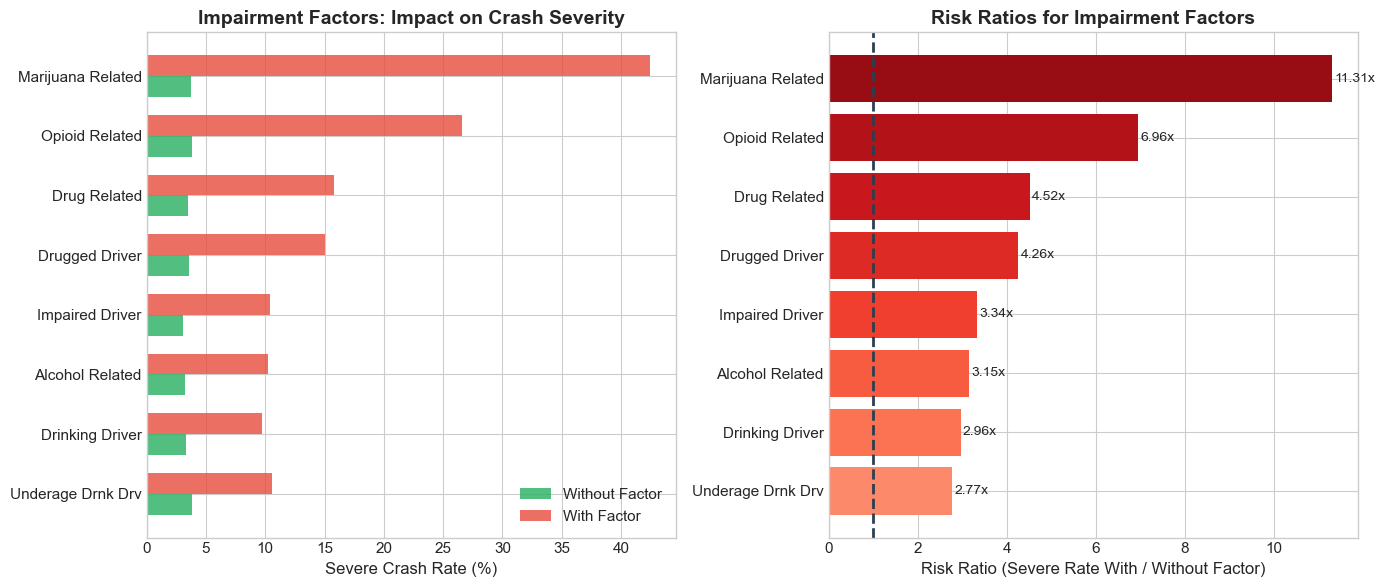

In [15]:
# ============================================================================
# CELL 15: IMPAIRMENT-RELATED RISK FACTORS
# ============================================================================

impairment_cols = ['ALCOHOL_RELATED', 'DRINKING_DRIVER', 'DRUG_RELATED', 'IMPAIRED_DRIVER', 
                   'DRUGGED_DRIVER', 'MARIJUANA_RELATED', 'OPIOID_RELATED', 'UNDERAGE_DRNK_DRV']
existing_impairment = [c for c in impairment_cols if c in df_crash.columns]

# Calculate severe rate for each factor
impairment_rates = []
for col in existing_impairment:
    with_factor = df_crash[df_crash[col] == 1]['TARGET_SEVERE'].mean() * 100
    without_factor = df_crash[df_crash[col] == 0]['TARGET_SEVERE'].mean() * 100
    prevalence = df_crash[col].mean() * 100
    impairment_rates.append({
        'Factor': col.replace('_', ' ').title(),
        'With_Factor': with_factor,
        'Without_Factor': without_factor,
        'Risk_Ratio': with_factor / without_factor if without_factor > 0 else 0,
        'Prevalence': prevalence
    })

impairment_df = pd.DataFrame(impairment_rates).sort_values('Risk_Ratio', ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Severe rate comparison
x = np.arange(len(impairment_df))
width = 0.35
axes[0].barh(x - width/2, impairment_df['Without_Factor'], width, label='Without Factor', color='#27ae60', alpha=0.8)
axes[0].barh(x + width/2, impairment_df['With_Factor'], width, label='With Factor', color='#e74c3c', alpha=0.8)
axes[0].set_yticks(x)
axes[0].set_yticklabels(impairment_df['Factor'])
axes[0].set_xlabel('Severe Crash Rate (%)')
axes[0].set_title('Impairment Factors: Impact on Crash Severity', fontweight='bold')
axes[0].legend()

# Plot 2: Risk ratio
colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(impairment_df)))
axes[1].barh(impairment_df['Factor'], impairment_df['Risk_Ratio'], color=colors)
axes[1].axvline(x=1, color='#2c3e50', linestyle='--', linewidth=2, label='No Difference')
axes[1].set_xlabel('Risk Ratio (Severe Rate With / Without Factor)')
axes[1].set_title('Risk Ratios for Impairment Factors', fontweight='bold')
for i, v in enumerate(impairment_df['Risk_Ratio']):
    axes[1].text(v + 0.05, i, f'{v:.2f}x', va='center', fontsize=10)

plt.tight_layout()
plt.show()

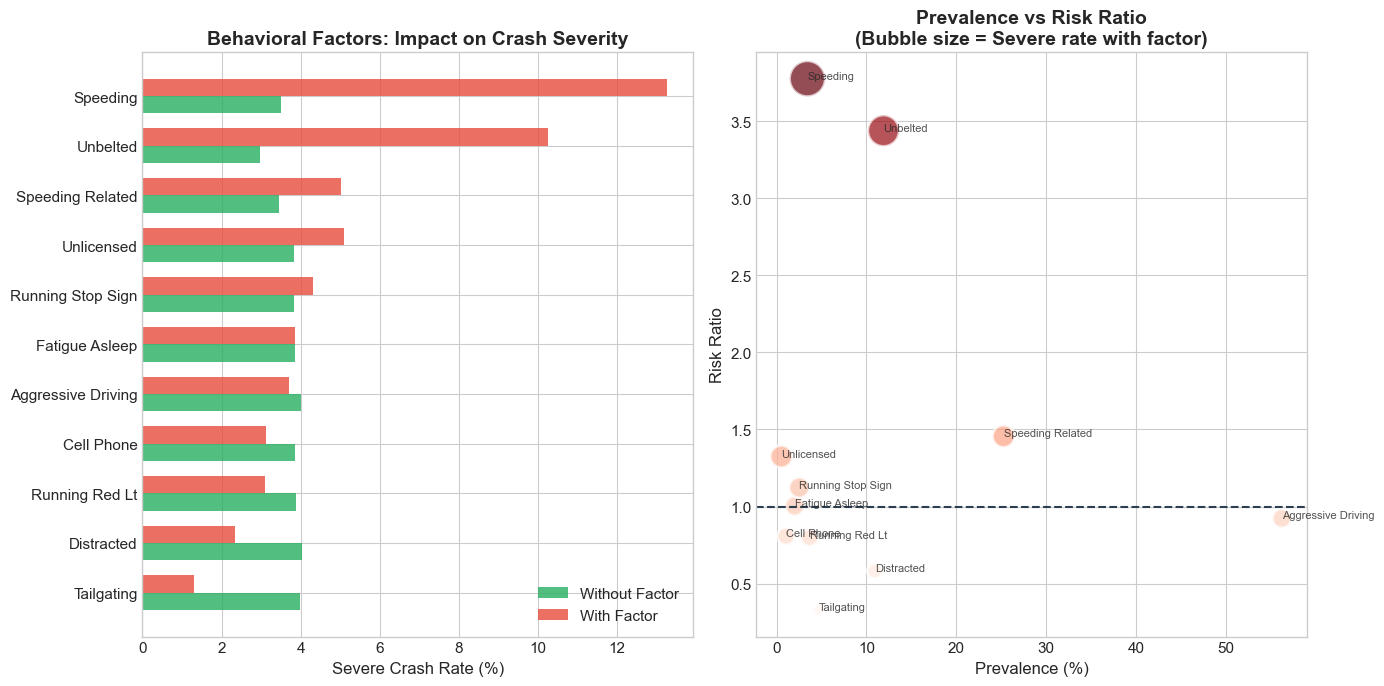

In [16]:
# ============================================================================
# CELL 16: BEHAVIORAL RISK FACTORS
# ============================================================================

behavior_cols = ['AGGRESSIVE_DRIVING', 'SPEEDING', 'SPEEDING_RELATED', 'DISTRACTED', 
                'CELL_PHONE', 'TAILGATING', 'RUNNING_RED_LT', 'RUNNING_STOP_SIGN',
                'UNBELTED', 'UNLICENSED', 'FATIGUE_ASLEEP']
existing_behavior = [c for c in behavior_cols if c in df_crash.columns]

# Calculate severe rate for each factor
behavior_rates = []
for col in existing_behavior:
    with_factor = df_crash[df_crash[col] == 1]['TARGET_SEVERE'].mean() * 100
    without_factor = df_crash[df_crash[col] == 0]['TARGET_SEVERE'].mean() * 100
    prevalence = df_crash[col].mean() * 100
    behavior_rates.append({
        'Factor': col.replace('_', ' ').title(),
        'With_Factor': with_factor,
        'Without_Factor': without_factor,
        'Risk_Ratio': with_factor / without_factor if without_factor > 0 else 0,
        'Prevalence': prevalence
    })

behavior_df = pd.DataFrame(behavior_rates).sort_values('Risk_Ratio', ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot 1: Severe rate comparison
x = np.arange(len(behavior_df))
width = 0.35
axes[0].barh(x - width/2, behavior_df['Without_Factor'], width, label='Without Factor', color='#27ae60', alpha=0.8)
axes[0].barh(x + width/2, behavior_df['With_Factor'], width, label='With Factor', color='#e74c3c', alpha=0.8)
axes[0].set_yticks(x)
axes[0].set_yticklabels(behavior_df['Factor'])
axes[0].set_xlabel('Severe Crash Rate (%)')
axes[0].set_title('Behavioral Factors: Impact on Crash Severity', fontweight='bold')
axes[0].legend()

# Plot 2: Prevalence vs Risk Ratio (bubble chart)
scatter = axes[1].scatter(behavior_df['Prevalence'], behavior_df['Risk_Ratio'],
                         s=behavior_df['With_Factor']*50, c=behavior_df['Risk_Ratio'],
                         cmap='Reds', alpha=0.7, edgecolors='white', linewidth=2)
axes[1].axhline(y=1, color='#2c3e50', linestyle='--', linewidth=1.5)
axes[1].set_xlabel('Prevalence (%)')
axes[1].set_ylabel('Risk Ratio')
axes[1].set_title('Prevalence vs Risk Ratio\n(Bubble size = Severe rate with factor)', fontweight='bold')
for _, row in behavior_df.iterrows():
    axes[1].annotate(row['Factor'], (row['Prevalence'], row['Risk_Ratio']), fontsize=8, alpha=0.8)

plt.tight_layout()
plt.show()

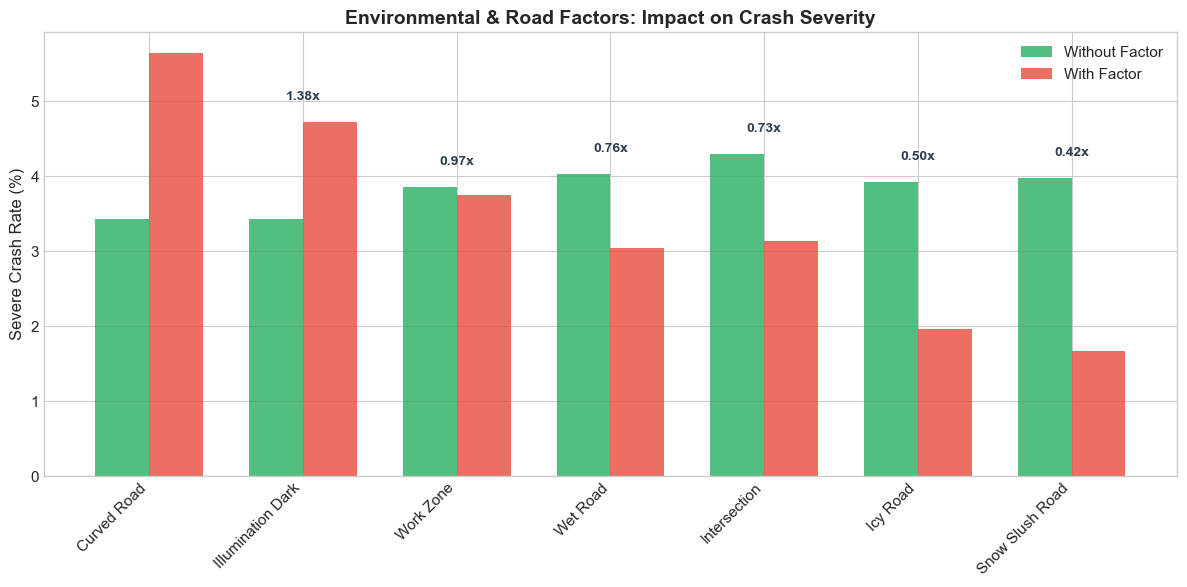

In [17]:
# ============================================================================
# CELL 17: ENVIRONMENTAL & ROAD CONDITION FACTORS
# ============================================================================

env_cols = ['ICY_ROAD', 'SNOW_SLUSH_ROAD', 'WET_ROAD', 'ILLUMINATION_DARK', 
           'CURVED_ROAD', 'INTERSECTION', 'WORK_ZONE']
existing_env = [c for c in env_cols if c in df_crash.columns]

# Calculate severe rate for each factor
env_rates = []
for col in existing_env:
    with_factor = df_crash[df_crash[col] == 1]['TARGET_SEVERE'].mean() * 100
    without_factor = df_crash[df_crash[col] == 0]['TARGET_SEVERE'].mean() * 100
    prevalence = df_crash[col].mean() * 100
    env_rates.append({
        'Factor': col.replace('_', ' ').title(),
        'With_Factor': with_factor,
        'Without_Factor': without_factor,
        'Risk_Ratio': with_factor / without_factor if without_factor > 0 else 0,
        'Prevalence': prevalence
    })

env_df = pd.DataFrame(env_rates).sort_values('Risk_Ratio', ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(env_df))
width = 0.35
bars1 = ax.bar(x - width/2, env_df['Without_Factor'], width, label='Without Factor', color='#27ae60', alpha=0.8)
bars2 = ax.bar(x + width/2, env_df['With_Factor'], width, label='With Factor', color='#e74c3c', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(env_df['Factor'], rotation=45, ha='right')
ax.set_ylabel('Severe Crash Rate (%)')
ax.set_title('Environmental & Road Factors: Impact on Crash Severity', fontweight='bold')
ax.legend()

# Add risk ratio annotations
for i, (_, row) in enumerate(env_df.iterrows()):
    ax.annotate(f'{row["Risk_Ratio"]:.2f}x', xy=(i, max(row['With_Factor'], row['Without_Factor']) + 0.3),
               ha='center', fontsize=10, fontweight='bold', color='#2c3e50')

plt.tight_layout()
plt.show()

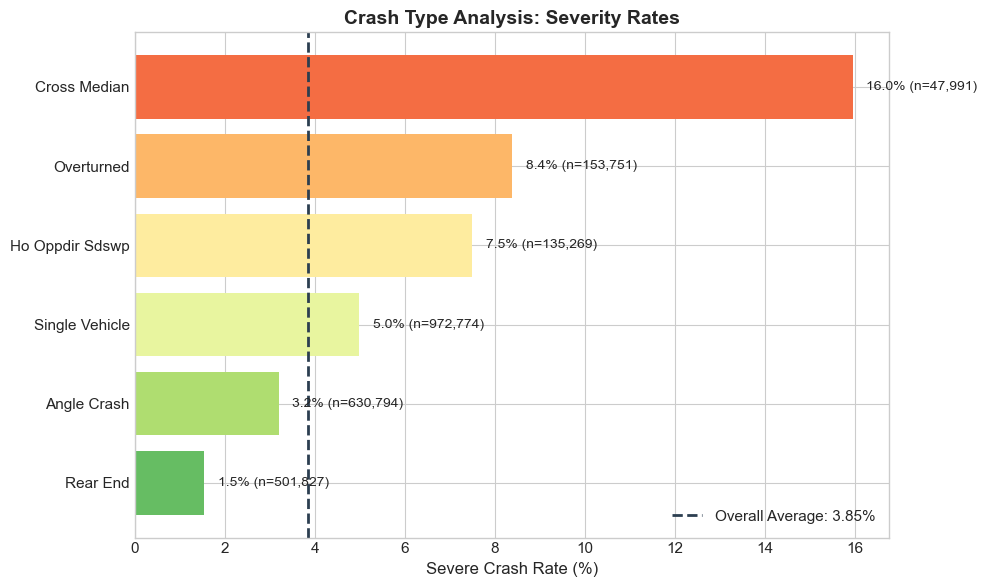


CRASH TYPE KEY FINDINGS

Most dangerous crash type: Cross Median (15.96% severe)
Least dangerous crash type: Rear End (1.54% severe)


In [18]:
# ============================================================================
# CELL 18: CRASH TYPE ANALYSIS
# ============================================================================

crash_type_cols = ['ANGLE_CRASH', 'REAR_END', 'HO_OPPDIR_SDSWP', 'SINGLE_VEHICLE', 
                  'OVERTURNED', 'CROSS_MEDIAN']
existing_types = [c for c in crash_type_cols if c in df_crash.columns]

# Calculate severe rate for each crash type
type_rates = []
for col in existing_types:
    crashes_with = df_crash[df_crash[col] == 1]
    severe_rate = crashes_with['TARGET_SEVERE'].mean() * 100
    count = len(crashes_with)
    type_rates.append({
        'Crash_Type': col.replace('_', ' ').title(),
        'Severe_Rate': severe_rate,
        'Count': count
    })

type_df = pd.DataFrame(type_rates).sort_values('Severe_Rate', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))

colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(type_df)))
bars = ax.barh(type_df['Crash_Type'], type_df['Severe_Rate'], color=colors)

ax.set_xlabel('Severe Crash Rate (%)')
ax.set_title('Crash Type Analysis: Severity Rates', fontweight='bold')
ax.axvline(x=df_crash['TARGET_SEVERE'].mean()*100, color='#2c3e50', linestyle='--', 
          linewidth=2, label=f'Overall Average: {df_crash["TARGET_SEVERE"].mean()*100:.2f}%')
ax.legend()

for bar, (_, row) in zip(bars, type_df.iterrows()):
    ax.text(bar.get_width() + 0.3, bar.get_y() + bar.get_height()/2,
           f'{row["Severe_Rate"]:.1f}% (n={row["Count"]:,})', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CRASH TYPE KEY FINDINGS")
print("="*60)
print(f"\nMost dangerous crash type: {type_df.iloc[-1]['Crash_Type']} ({type_df.iloc[-1]['Severe_Rate']:.2f}% severe)")
print(f"Least dangerous crash type: {type_df.iloc[0]['Crash_Type']} ({type_df.iloc[0]['Severe_Rate']:.2f}% severe)")

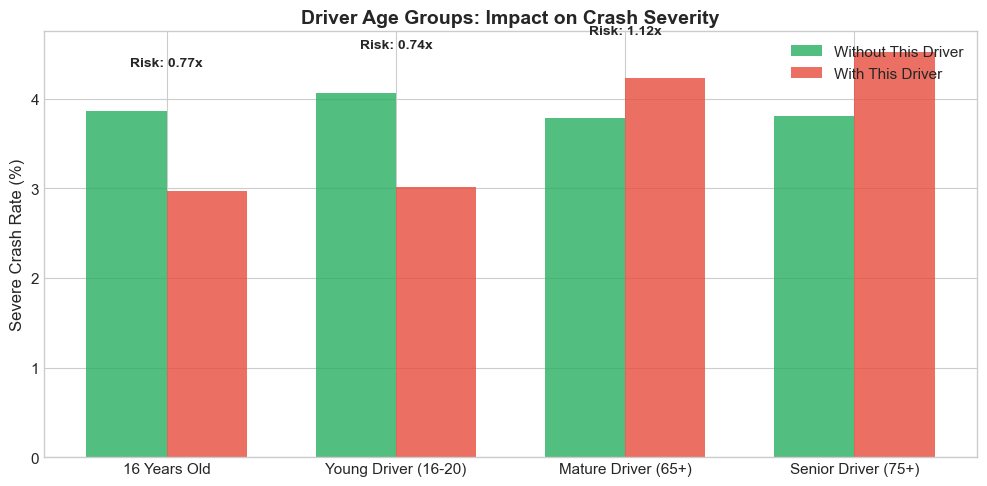

In [19]:
# ============================================================================
# CELL 19: DRIVER AGE GROUP ANALYSIS
# ============================================================================

age_cols = ['DRIVER_16YR', 'YOUNG_DRIVER', 'MATURE_DRIVER', 'DRIVER_75PLUS']
existing_age = [c for c in age_cols if c in df_crash.columns]

age_labels = {
    'DRIVER_16YR': '16 Years Old',
    'YOUNG_DRIVER': 'Young Driver (16-20)',
    'MATURE_DRIVER': 'Mature Driver (65+)',
    'DRIVER_75PLUS': 'Senior Driver (75+)'
}

age_rates = []
for col in existing_age:
    with_factor = df_crash[df_crash[col] == 1]['TARGET_SEVERE'].mean() * 100
    without_factor = df_crash[df_crash[col] == 0]['TARGET_SEVERE'].mean() * 100
    prevalence = df_crash[col].mean() * 100
    age_rates.append({
        'Age_Group': age_labels.get(col, col),
        'With_Driver': with_factor,
        'Without_Driver': without_factor,
        'Risk_Ratio': with_factor / without_factor if without_factor > 0 else 0,
        'Prevalence': prevalence
    })

age_df = pd.DataFrame(age_rates)

fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(age_df))
width = 0.35
ax.bar(x - width/2, age_df['Without_Driver'], width, label='Without This Driver', color='#27ae60', alpha=0.8)
ax.bar(x + width/2, age_df['With_Driver'], width, label='With This Driver', color='#e74c3c', alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(age_df['Age_Group'])
ax.set_ylabel('Severe Crash Rate (%)')
ax.set_title('Driver Age Groups: Impact on Crash Severity', fontweight='bold')
ax.legend()

# Add risk ratio
for i, (_, row) in enumerate(age_df.iterrows()):
    ax.annotate(f'Risk: {row["Risk_Ratio"]:.2f}x', xy=(i, max(row['With_Driver'], row['Without_Driver']) + 0.5),
               ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

---
## 6. Feature Correlation Analysis
---

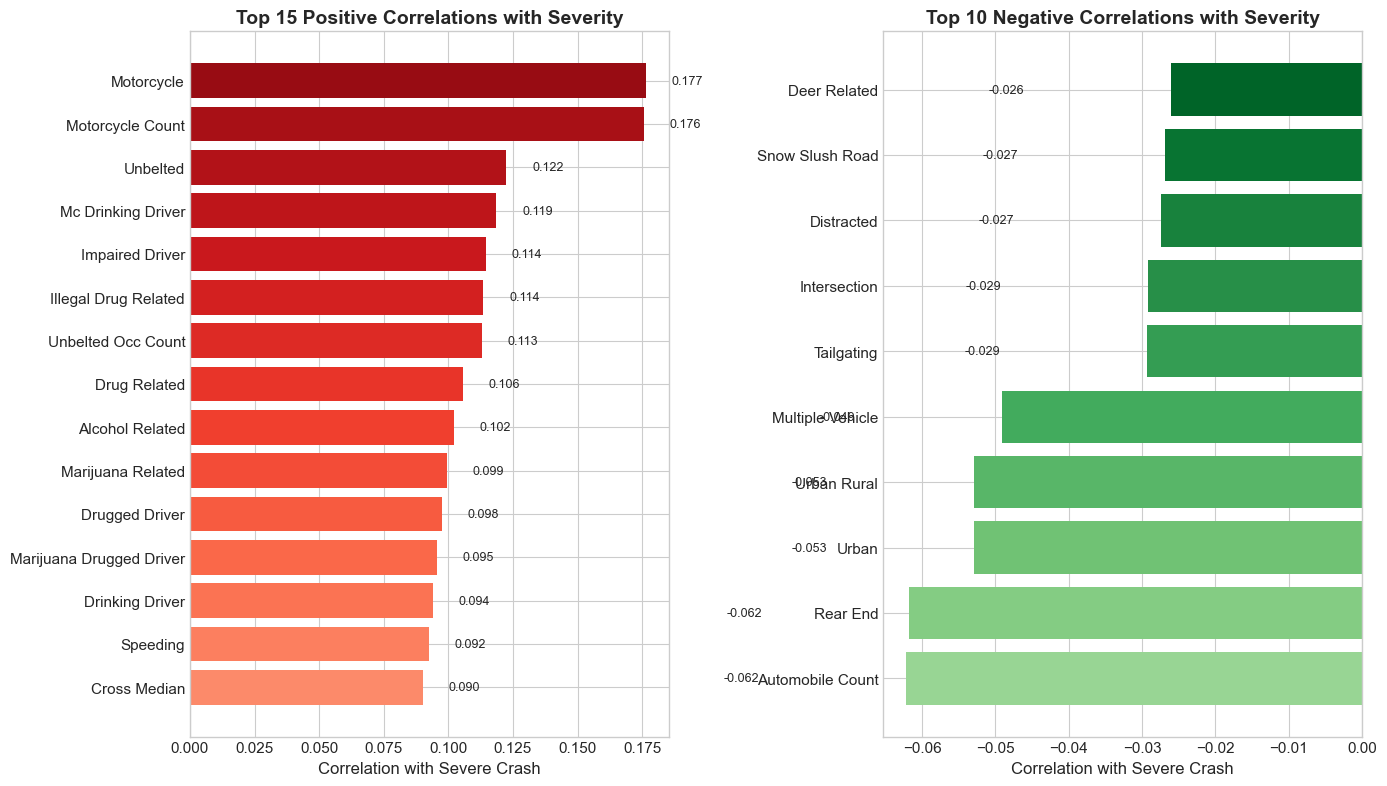

In [20]:
# ============================================================================
# CELL 20: CORRELATION WITH TARGET VARIABLE
# ============================================================================

# Select numeric features for correlation
numeric_cols = df_crash.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['CRN', 'CRASH_YEAR', 'CRASH_MONTH', 'COUNTY', 'LONGITUDE', 'LATITUDE', 
               'DEC_LONG', 'DEC_LAT', 'TARGET_SEVERE']
feature_cols = [c for c in numeric_cols if c not in exclude_cols]

# Calculate correlations with target
correlations = df_crash[feature_cols + ['TARGET_SEVERE']].corr()['TARGET_SEVERE'].drop('TARGET_SEVERE')
correlations = correlations.sort_values(ascending=False)

# Top and bottom correlated features
top_positive = correlations.head(15)
top_negative = correlations.tail(10)

fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Plot 1: Top positive correlations
colors_pos = plt.cm.Reds(np.linspace(0.4, 0.9, len(top_positive)))[::-1]
axes[0].barh(range(len(top_positive)), top_positive.values, color=colors_pos)
axes[0].set_yticks(range(len(top_positive)))
axes[0].set_yticklabels([c.replace('_', ' ').title() for c in top_positive.index])
axes[0].set_xlabel('Correlation with Severe Crash')
axes[0].set_title('Top 15 Positive Correlations with Severity', fontweight='bold')
axes[0].invert_yaxis()
for i, v in enumerate(top_positive.values):
    axes[0].text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

# Plot 2: Top negative correlations
colors_neg = plt.cm.Greens(np.linspace(0.9, 0.4, len(top_negative)))
axes[1].barh(range(len(top_negative)), top_negative.values, color=colors_neg)
axes[1].set_yticks(range(len(top_negative)))
axes[1].set_yticklabels([c.replace('_', ' ').title() for c in top_negative.index])
axes[1].set_xlabel('Correlation with Severe Crash')
axes[1].set_title('Top 10 Negative Correlations with Severity', fontweight='bold')
axes[1].invert_yaxis()
for i, v in enumerate(top_negative.values):
    axes[1].text(v - 0.02, i, f'{v:.3f}', va='center', ha='right', fontsize=9)

plt.tight_layout()
plt.show()

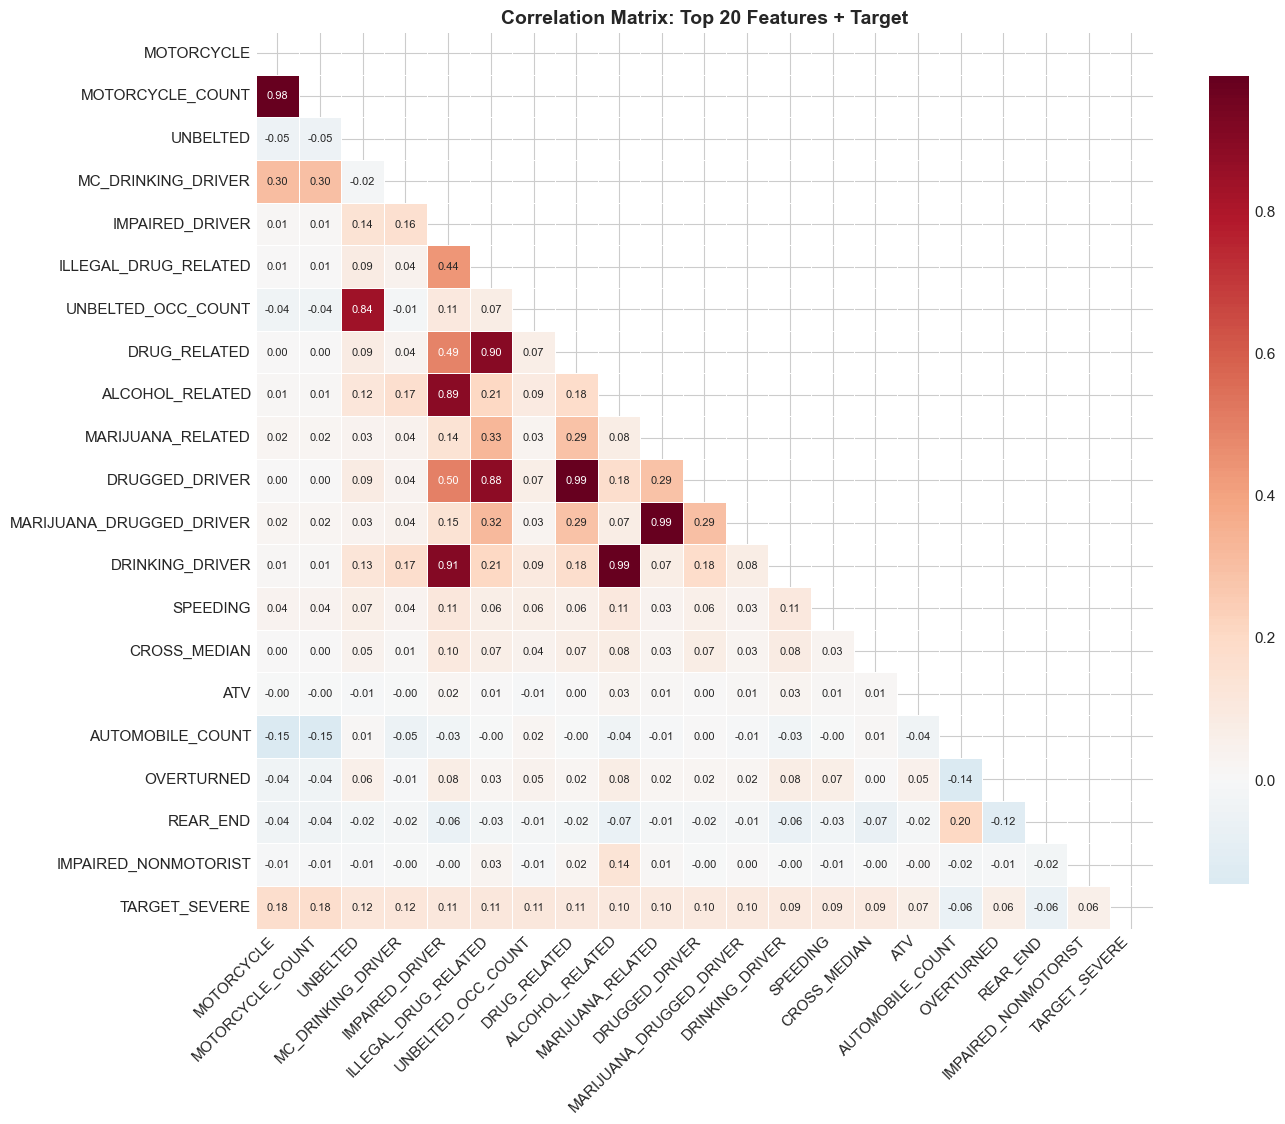

In [21]:
# ============================================================================
# CELL 21: FEATURE CORRELATION MATRIX (TOP PREDICTORS)
# ============================================================================

# Select top features based on correlation magnitude
top_features = correlations.abs().nlargest(20).index.tolist()

# Compute correlation matrix
corr_matrix = df_crash[top_features + ['TARGET_SEVERE']].corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
           center=0, square=True, linewidths=0.5, annot_kws={'size': 8},
           cbar_kws={'shrink': 0.8})
ax.set_title('Correlation Matrix: Top 20 Features + Target', fontweight='bold', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---
## 7. Aggregated Features Analysis (County-Month Level)
---

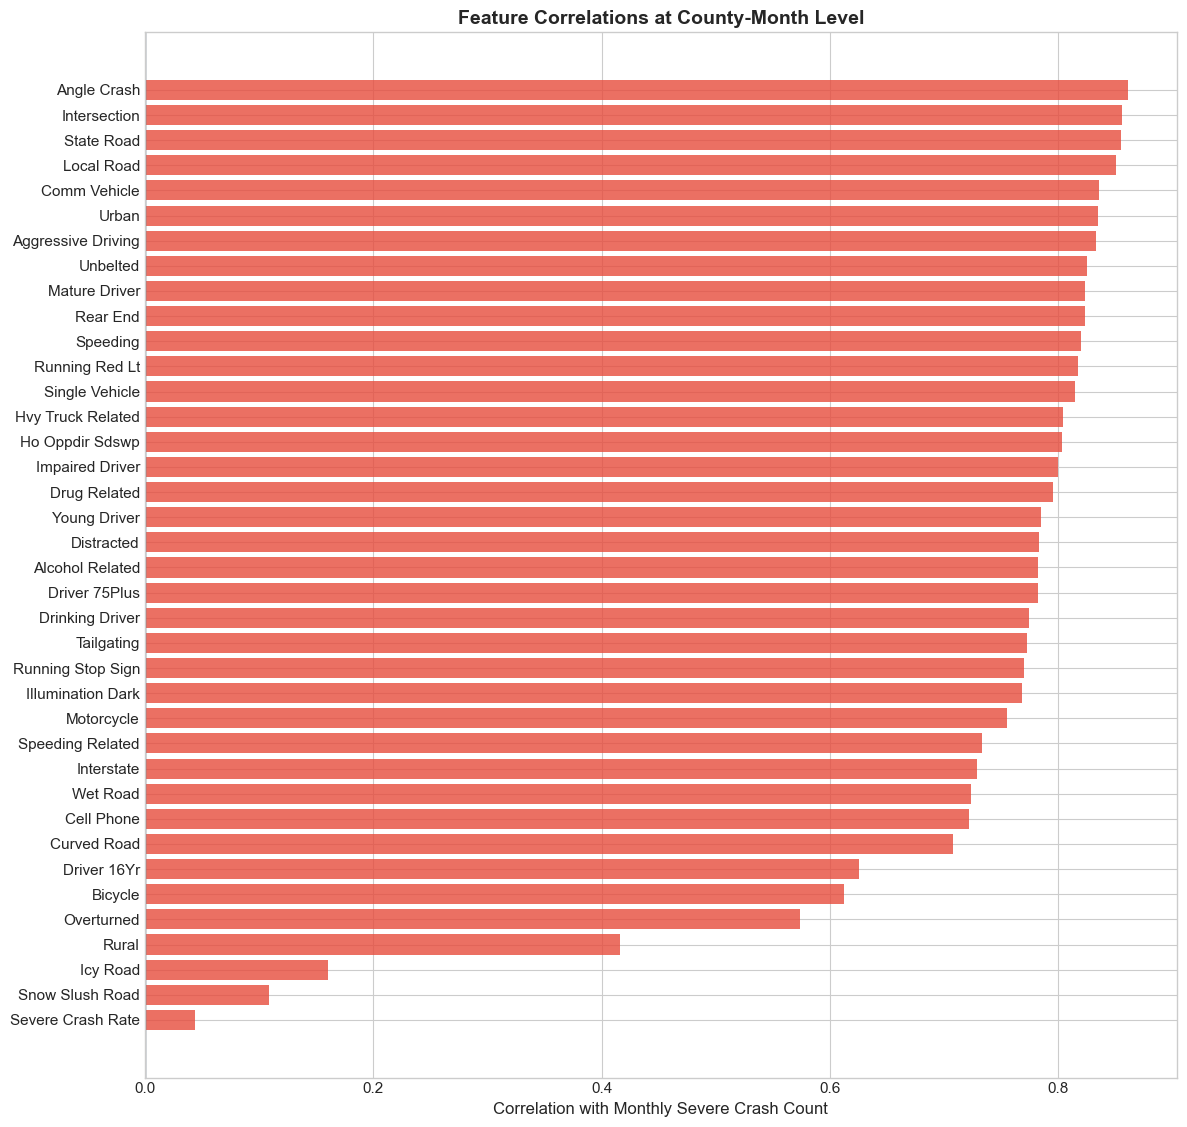


Top 10 Predictors for County-Month Severe Crash Count:
  ANGLE_CRASH: 0.8609
  INTERSECTION: 0.8560
  STATE_ROAD: 0.8546
  LOCAL_ROAD: 0.8502
  COMM_VEHICLE: 0.8360
  URBAN: 0.8349
  AGGRESSIVE_DRIVING: 0.8333
  UNBELTED: 0.8255
  MATURE_DRIVER: 0.8238
  REAR_END: 0.8232


In [22]:
# ============================================================================
# CELL 22: FEATURE CORRELATIONS AT AGGREGATED LEVEL
# ============================================================================

# Get numeric columns from aggregated data
agg_numeric = df_monthly.select_dtypes(include=[np.number]).columns.tolist()
exclude_agg = ['COUNTY', 'CRASH_YEAR', 'CRASH_MONTH', 'SEVERE_CRASH_COUNT', 'TOTAL_CRASH_COUNT']
agg_features = [c for c in agg_numeric if c not in exclude_agg]

if len(agg_features) > 0:
    # Calculate correlations with target
    agg_correlations = df_monthly[agg_features + ['SEVERE_CRASH_COUNT']].corr()['SEVERE_CRASH_COUNT'].drop('SEVERE_CRASH_COUNT')
    agg_correlations = agg_correlations.sort_values(ascending=False)
    
    fig, ax = plt.subplots(figsize=(12, max(8, len(agg_correlations)*0.3)))
    
    colors = ['#e74c3c' if x > 0 else '#27ae60' for x in agg_correlations.values]
    ax.barh(range(len(agg_correlations)), agg_correlations.values, color=colors, alpha=0.8)
    ax.set_yticks(range(len(agg_correlations)))
    ax.set_yticklabels([c.replace('_', ' ').title() for c in agg_correlations.index])
    ax.set_xlabel('Correlation with Monthly Severe Crash Count')
    ax.set_title('Feature Correlations at County-Month Level', fontweight='bold')
    ax.axvline(x=0, color='#2c3e50', linestyle='-', linewidth=1)
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()
    
    print("\nTop 10 Predictors for County-Month Severe Crash Count:")
    for feat, corr in agg_correlations.head(10).items():
        print(f"  {feat}: {corr:.4f}")

---
## 8. Time Series Example: Selected Counties
---

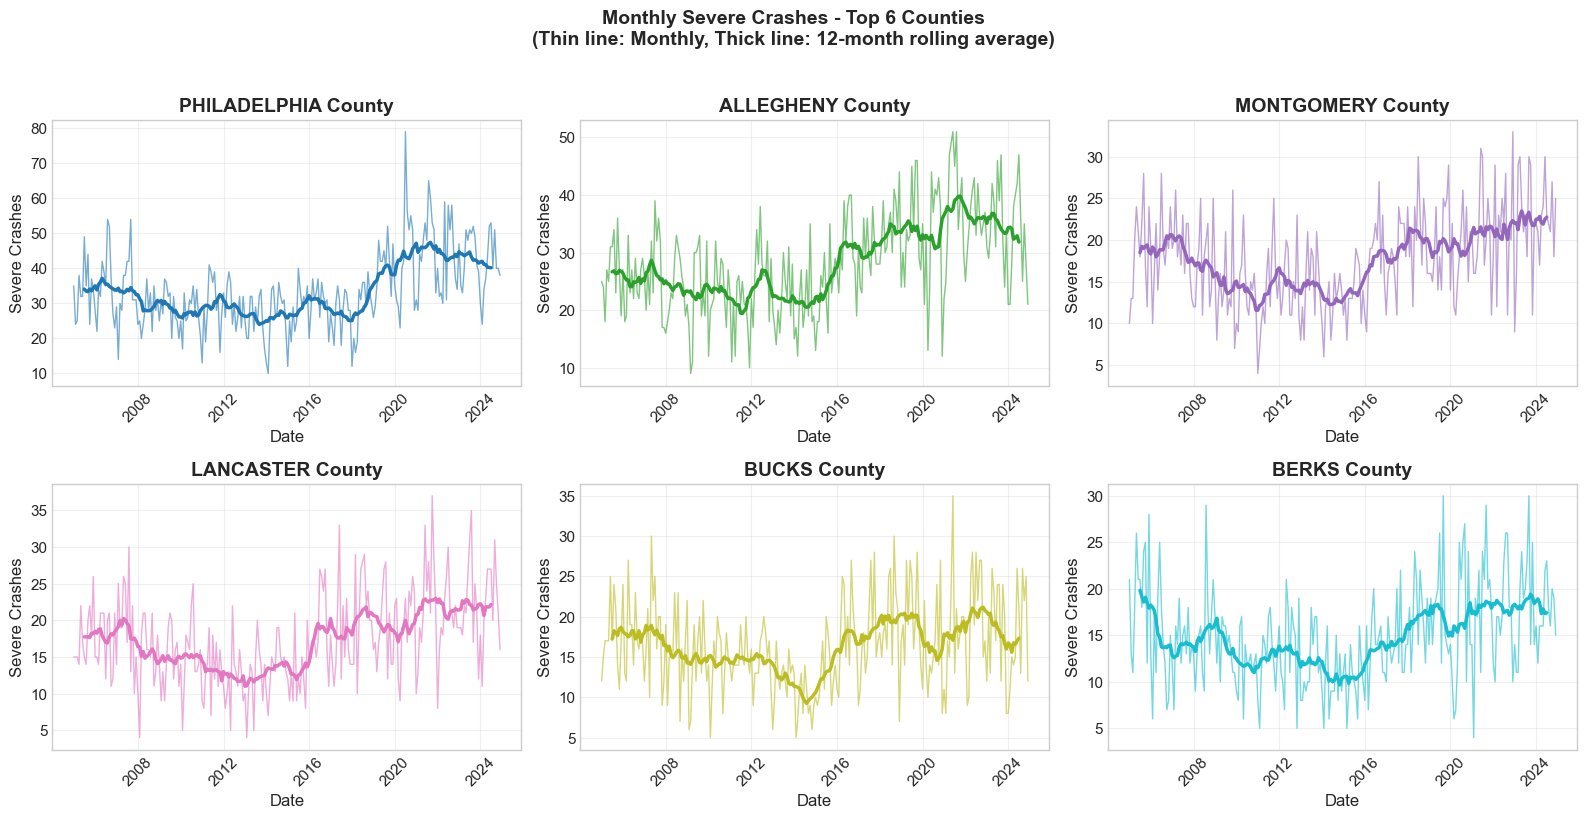

In [23]:
# ============================================================================
# CELL 23: TIME SERIES FOR TOP COUNTIES
# ============================================================================

# Get top 6 counties by total severe crashes
top_counties = county_agg.nlargest(6, 'Severe_Crashes')['County'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(16, 8))
axes = axes.flatten()

colors = plt.cm.tab10(np.linspace(0, 1, 6))

for i, county in enumerate(top_counties):
    county_data = df_monthly[df_monthly['COUNTY_DESC'] == county].copy()
    county_data['Date'] = pd.to_datetime(
        county_data['CRASH_YEAR'].astype(str) + '-' + 
        county_data['CRASH_MONTH'].astype(str).str.zfill(2) + '-01'
    )
    county_data = county_data.sort_values('Date')
    
    axes[i].plot(county_data['Date'], county_data['SEVERE_CRASH_COUNT'], 
                color=colors[i], alpha=0.6, linewidth=1)
    
    # Add 12-month rolling average
    rolling = county_data['SEVERE_CRASH_COUNT'].rolling(window=12, center=True).mean()
    axes[i].plot(county_data['Date'], rolling, color=colors[i], linewidth=2.5)
    
    axes[i].set_title(f'{county} County', fontweight='bold')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Severe Crashes')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Monthly Severe Crashes - Top 6 Counties\n(Thin line: Monthly, Thick line: 12-month rolling average)', 
            fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
## 9. Summary & Key Insights for Forecasting
---

In [24]:
# ============================================================================
# CELL 24: SUMMARY STATISTICS AND KEY INSIGHTS
# ============================================================================

print("="*80)
print("                    EDA SUMMARY FOR SEVERE CRASH FORECASTING")
print("="*80)

print("\n" + "-"*40)
print("DATASET OVERVIEW")
print("-"*40)
print(f"Total Crashes: {len(df_crash):,}")
print(f"Severe Crashes: {df_crash['TARGET_SEVERE'].sum():,} ({df_crash['TARGET_SEVERE'].mean()*100:.2f}%)")
print(f"Years Covered: {df_crash['CRASH_YEAR'].min()} - {df_crash['CRASH_YEAR'].max()}")
print(f"Counties: {df_crash['COUNTY'].nunique()}")
print(f"Aggregated Observations: {len(df_monthly):,} county-months")

print("\n" + "-"*40)
print("TARGET VARIABLE (County-Month Level)")
print("-"*40)
print(f"Mean: {df_monthly['SEVERE_CRASH_COUNT'].mean():.2f}")
print(f"Median: {df_monthly['SEVERE_CRASH_COUNT'].median():.2f}")
print(f"Std Dev: {df_monthly['SEVERE_CRASH_COUNT'].std():.2f}")
print(f"Range: {df_monthly['SEVERE_CRASH_COUNT'].min()} - {df_monthly['SEVERE_CRASH_COUNT'].max()}")

print("\n" + "-"*40)
print("KEY TEMPORAL PATTERNS")
print("-"*40)
print("• Clear seasonal patterns observed")
print(f"• Summer months show {'higher' if seasonal_agg[seasonal_agg['Season']=='Summer']['Severe_Rate'].values[0] > seasonal_agg['Severe_Rate'].mean() else 'lower'} severe crash rates")
print("• Long-term trend shows variation over years")

print("\n" + "-"*40)
print("TOP RISK FACTORS (By Risk Ratio)")
print("-"*40)
all_risk_factors = pd.concat([impairment_df, behavior_df, env_df]).sort_values('Risk_Ratio', ascending=False)
for _, row in all_risk_factors.head(10).iterrows():
    print(f"• {row['Factor']}: {row['Risk_Ratio']:.2f}x higher severe crash rate")

print("\n" + "-"*40)
print("GEOGRAPHIC INSIGHTS")
print("-"*40)
print(f"• Highest volume county: {county_agg.nlargest(1, 'Severe_Crashes')['County'].values[0]}")
print(f"• Highest rate county: {county_agg.nlargest(1, 'Severe_Rate')['County'].values[0]}")
print("• Rural areas have significantly higher severe crash rates than urban areas")

print("\n" + "-"*40)
print("RECOMMENDED FEATURES FOR FORECASTING MODEL")
print("-"*40)
print("1. Temporal: CRASH_YEAR, CRASH_MONTH, SEASON")
print("2. Geographic: COUNTY, URBAN/RURAL ratios")
print("3. Risk Factors (aggregated counts):")
print("   - Impairment: ALCOHOL_RELATED, IMPAIRED_DRIVER, DRUG_RELATED")
print("   - Behavioral: SPEEDING, UNBELTED, AGGRESSIVE_DRIVING")
print("   - Environmental: ICY_ROAD, SNOW_SLUSH_ROAD, ILLUMINATION_DARK")
print("   - Crash types: MOTORCYCLE, SINGLE_VEHICLE, OVERTURNED")
print("4. Historical: Lagged severe crash counts (t-1, t-12)")

print("\n" + "="*80)

                    EDA SUMMARY FOR SEVERE CRASH FORECASTING

----------------------------------------
DATASET OVERVIEW
----------------------------------------
Total Crashes: 2,387,466
Severe Crashes: 91,885.0 (3.85%)
Years Covered: 2005 - 2024
Counties: 67
Aggregated Observations: 16,068 county-months

----------------------------------------
TARGET VARIABLE (County-Month Level)
----------------------------------------
Mean: 5.72
Median: 3.00
Std Dev: 6.88
Range: 0.0 - 79.0

----------------------------------------
KEY TEMPORAL PATTERNS
----------------------------------------
• Clear seasonal patterns observed
• Summer months show higher severe crash rates
• Long-term trend shows variation over years

----------------------------------------
TOP RISK FACTORS (By Risk Ratio)
----------------------------------------
• Marijuana Related: 11.31x higher severe crash rate
• Opioid Related: 6.96x higher severe crash rate
• Drug Related: 4.52x higher severe crash rate
• Drugged Driver: 4.26

In [25]:
# ============================================================================
# CELL 25: SAVE AGGREGATED DATASET FOR MODELING
# ============================================================================

# Save the aggregated county-month dataset
output_file = 'pa_crash_county_month_aggregated.csv'
df_monthly.to_csv(output_file, index=False)
print(f"Aggregated dataset saved to: {output_file}")
print(f"Shape: {df_monthly.shape}")
print(f"\nColumns: {list(df_monthly.columns)}")

Aggregated dataset saved to: pa_crash_county_month_aggregated.csv
Shape: (16068, 45)

Columns: ['COUNTY', 'COUNTY_DESC', 'CRASH_YEAR', 'CRASH_MONTH', 'SEASON', 'SEVERE_CRASH_COUNT', 'TOTAL_CRASH_COUNT', 'ALCOHOL_RELATED', 'DRINKING_DRIVER', 'DRUG_RELATED', 'IMPAIRED_DRIVER', 'AGGRESSIVE_DRIVING', 'SPEEDING', 'SPEEDING_RELATED', 'DISTRACTED', 'CELL_PHONE', 'TAILGATING', 'RUNNING_RED_LT', 'RUNNING_STOP_SIGN', 'UNBELTED', 'ICY_ROAD', 'SNOW_SLUSH_ROAD', 'WET_ROAD', 'ILLUMINATION_DARK', 'CURVED_ROAD', 'INTERSTATE', 'STATE_ROAD', 'LOCAL_ROAD', 'INTERSECTION', 'ANGLE_CRASH', 'REAR_END', 'HO_OPPDIR_SDSWP', 'SINGLE_VEHICLE', 'OVERTURNED', 'MOTORCYCLE', 'BICYCLE', 'HVY_TRUCK_RELATED', 'COMM_VEHICLE', 'YOUNG_DRIVER', 'MATURE_DRIVER', 'DRIVER_16YR', 'DRIVER_75PLUS', 'URBAN', 'RURAL', 'SEVERE_CRASH_RATE']
